# Novelty detection using 1-class SVM

Classifies new data as similar or different to the training set.  This method is an unsupervised method that builds a decision boundary between the data and origin in kernel space and can be used as a novelty detector.

In [1]:
%load_ext sql

/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# Greenplum Database 5.4.0 on GCP (demo machine)
%sql postgresql://gpadmin@35.184.253.255:5432/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

# Greenplum Database 4.3.10.0
#%sql postgresql://gpdbchina@10.194.10.68:61000/madlib

u'Connected: gpadmin@madlib'

In [3]:
# Setup
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager

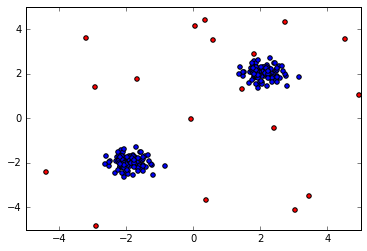

In [4]:
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X_train_D = pd.DataFrame(X_train, columns=['x1', 'x2'])

# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-7, high=7, size=(40, 2))
X_outliers_D = pd.DataFrame(X_outliers, columns=['x1', 'x2'])

b = plt.scatter(X_train[:, 0], X_train[:, 1], c='blue')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()

In [5]:
# Build tables
%sql DROP TABLE IF EXISTS X_train_D CASCADE
%sql PERSIST X_train_D
%sql ALTER TABLE X_train_D add column X float[]
%sql update X_train_D set X = array[x1, x2]::float[]

%sql DROP TABLE IF EXISTS X_outliers_D CASCADE
%sql PERSIST X_outliers_D
%sql ALTER TABLE X_outliers_D add column X float[]
%sql update X_outliers_D set X = array[x1, x2]::float[]

Done.
Done.
200 rows affected.
Done.
Done.
40 rows affected.


[]

In [6]:
%%sql 
-- Train the model
DROP TABLE IF EXISTS svm_out1, svm_out1_summary, svm_out1_random CASCADE;
SELECT madlib.svm_one_class(
    'X_train_D',    -- source table
    'svm_out1',     -- output table
    'X',            -- features
    'gaussian',     -- kernel
    'gamma=1, n_components=55, random_state=3', 
    NULL,           -- grouping 
    'init_stepsize=0.1, lambda=10, max_iter=100, tolerance=0'  
    );
SELECT * FROM svm_out1; 

Done.
1 rows affected.
1 rows affected.


coef,loss,norm_of_gradient,num_iterations,num_rows_processed,num_rows_skipped,dep_var_mapping
"[-0.0432454845758051, -0.159444816692118, -0.737806938475955, 0.0534370865459891, -0.302783984437678, 0.216663708966247, 0.413951840077392, -0.624686692573685, 0.383245902283947, -0.93194741477619, 0.398359325873191, -0.106725591800195, -0.149623841552614, -0.0586264154241909, -0.0712714894313125, -0.752820609462399, -0.0387893518368972, -0.902369710478552, -0.559534808391375, -0.525734075427885, -0.125932502169152, -0.159125403795632, -0.554052542709238, -0.295316988845407, -0.343813368149046, -0.144503832215855, 0.372471877108083, 0.482314750223444, 0.43941447611859, -0.251685614368991, -0.167096578461358, 0.33496817207315, -0.0951761758107272, 0.617859995418938, 0.481179708913367, 0.425753691404979, 0.142601387350667, -0.0702737675277522, -0.625499347350069, -0.10838092278605, 0.659909999982923, 0.189460860381574, 0.560772005661166, 0.637457997296956, 0.142566086425306, 0.307329400451873, -0.0570729145059836, 0.0923408623395759, 0.673831714495205, 0.745802707398761, -0.12887594773649, -0.226376229070672, 0.358019840034591, -0.285312281448689, -0.4181210434903, -1.00005186868902]",0.115298833215,114.886308162,100,201,-1,"[-1.0, 1.0]"


In [8]:
# Prediction
# First for the training data
%sql drop table if exists y_pred_train;
%sql SELECT madlib.svm_predict('svm_out1', 'X_train_D', 'index', 'y_pred_train');
y_pred_train = %sql SELECT * from y_pred_train; 

# Next for the outliers
%sql drop table if exists y_pred_outliers;
%sql SELECT madlib.svm_predict('svm_out1', 'X_outliers_D', 'index', 'y_pred_outliers');
y_pred_outliers = %sql SELECT * from y_pred_outliers; 

#%sql SELECT * FROM y_pred_outliers limit 20; -- Show the outliers
%sql SELECT * FROM y_pred_train limit 20; -- Show the training data

Done.
1 rows affected.
200 rows affected.
Done.
1 rows affected.
40 rows affected.
20 rows affected.


index,prediction,decision_function
3,1.0,0.915642435444
11,1.0,0.977872869017
19,1.0,1.0855373153
27,1.0,0.79941793621
35,1.0,0.733618196408
43,1.0,0.837947132017
51,1.0,0.972880103728
59,1.0,0.694748057993
1,1.0,1.10798285659
9,1.0,0.951860111855


In [9]:
# Predict over the decision grid for plotting
# xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1', 'x2'])

%sql DROP TABLE IF EXISTS grid_points CASCADE
%sql PERSIST grid_points
%sql ALTER TABLE grid_points add column X float[]
%sql update grid_points set X = array[x1, x2]::float[]

Done.
Done.
10000 rows affected.


[]

Done.
1 rows affected.
10000 rows affected.


/Users/fmcquillan/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/fmcquillan/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


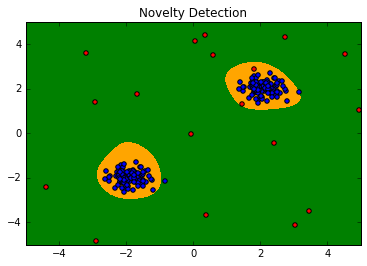

In [10]:
# Plot the decision grid
%sql drop table if exists Z_D;
%sql SELECT madlib.svm_predict('svm_out1', 'grid_points', 'index', 'Z_D');
Z_D = %sql SELECT decision_function from Z_D order by index
Z = np.array(Z_D)
Z = Z.reshape(xx.shape)

# Orange is not novel, green is novel
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')
plt.contourf(xx, yy, Z, levels=[Z.min(), 0], colors='green')
#plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), cmap=plt.cm.Blues_r)
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='blue')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()